In [2]:
"""This file contains the code to show the separative power of embeddings."""
import sys
import torch
import pandas as pd
import numpy as np
import pickle

sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")
# from src.data.data_processing import configure_model_inputs, gather_set_indices
from src.visualization.visualize import plot_label_count_in_datasets

import matplotlib.pyplot as plt
from src.general.utils import cc_path
import io
from src.data.data_loader import DataLoader
import umap.plot

def gather_set_indices(subsample_size: int, total_dataset_size: int, sampled_author):
    """
    Get the indices for each of the dataset
    Args:
        subsample_size (int): size we downsampled to
        total_dataset_size (int): total size of the dataset
        sampled_author (): the author network

    Returns:
        indices for each dataset split and the mapping from node to label
    """
    # when sample is downsized (for speed) need a new node to integer mapping for ids to be incremental
    if subsample_size < total_dataset_size:
        node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))
    else:
        with open(cc_path("data/pui_idx_mapping.json"), "r") as outfile:
            node_label_mapping = json.load(outfile)

    with open(cc_path(f'data/train_indices.txt')) as f:
        train_puis = f.read().splitlines()
        train_indices = list(map(node_label_mapping.get, train_puis))
    with open(cc_path(f'data/val_indices.txt')) as f:
        val_puis = f.read().splitlines()
        val_indices = list(map(node_label_mapping.get, val_puis))
    with open(cc_path(f'data/test_indices.txt')) as f:
        test_puis = f.read().splitlines()
        test_indices = list(map(node_label_mapping.get, test_puis))

    # if downsampled, not all original puis are in our trainset, so drop those
    if subsample_size < total_dataset_size:
        train_indices = [idx for idx in train_indices if idx]
        val_indices = [idx for idx in val_indices if idx]
        test_indices = [idx for idx in test_indices if idx]

    return train_indices, val_indices, test_indices, node_label_mapping

def configure_model_inputs(all_torch_data, data_type_to_use):
    data = [all_torch_data[datatype] for datatype in data_type_to_use]
    data_inputs = [d for data_object in data for d in (data_object.x.float(), data_object.edge_index)]

    if 'label' in data_type_to_use:
        data_inputs.append(all_torch_data['label'].edge_weight.float())

    return data, data_inputs

def umap_vis(embedding, target, label_name='test', embedding_type='SciBERT'):
    mapper = umap.UMAP().fit(embedding)
    print(labels)
    umap.plot.points(mapper, labels=target)
    plt.savefig('test_umap.png')

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)



    
    


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/.conda/envs/articleclassifier/lib/python3.9

In [3]:


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# load model
load_laha_trained_model = '20230519071949'
load_scibert_trained_model = '20230512142814'

best_model = torch.load(cc_path(f'models/supervised_graphs/{load_laha_trained_model}_supervised.pt'), map_location=torch.device(device))

best_scibert_model = torch.load(cc_path(f'models/supervised_graphs/{load_scibert_trained_model}_supervised.pt'), map_location=torch.device(device))


# load necessary data
with open(cc_path(f'data/processed/canary/torch_networks_full_{0.0149}_56337_label_specific.pickle'), 'rb') as handle:
#     all_torch_data = CPU_Unpickler(handle).load()
    all_torch_data = pickle.load(handle)

with open(cc_path(f'data/processed/canary/torch_networks_full_{0.0149}_56337_scibert.pickle'), 'rb') as handle:
#     all_torch_data = CPU_Unpickler(handle).load()
    all_scibert_torch_data = pickle.load(handle)
    
    # all_torch_data = torch.load(handle, map_location=torch.device('cpu'))
with open(cc_path('data/processed/canary/labels.pickle'), 'rb') as handle:
    label_columns = pd.read_pickle(handle)


{key: value.to(device) for key, value in all_torch_data.items()}
_, data_inputs = configure_model_inputs(all_torch_data, ['keyword'])
_, scibert_data_inputs = configure_model_inputs(all_scibert_torch_data, ['keyword'])

# load text embeddings
loc_dict = {
        'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
        'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
        'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_finetuned_20230425.csv'),
        'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
        'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
        'author_network': cc_path('data/processed/canary/author_network.pickle'),
        'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
    }

data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
label_columns = processed_df.loc[:, ~processed_df.columns.isin(
        ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
         'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

with open(cc_path(f'data/canary_train_indices.txt')) as f:
    train_puis = f.read().splitlines()
    # train_indices = list(map(node_label_mapping.get, train_puis))
with open(cc_path(f'data/canary_val_indices.txt')) as f:
    val_puis = f.read().splitlines()
    # val_indices = list(map(node_label_mapping.get, val_puis))
with open(cc_path(f'data/canary_test_indices.txt')) as f:
    test_puis = f.read().splitlines()
    # test_indices = list(map(node_label_mapping.get, test_puis))


    
# create graph embedding
graph_created_embeddings = best_model.forward(*data_inputs, return_embeddings=True)
X_test_graph_embeddings = graph_created_embeddings[all_torch_data['keyword'].test_mask].detach().cpu().numpy().astype(np.float32)
y_test_graph_embeddings = all_torch_data['keyword'].y[all_torch_data['keyword'].test_mask].detach().cpu().numpy().astype(int)
    
    

In [4]:


labels = label_columns.columns.difference(['pui']).tolist()

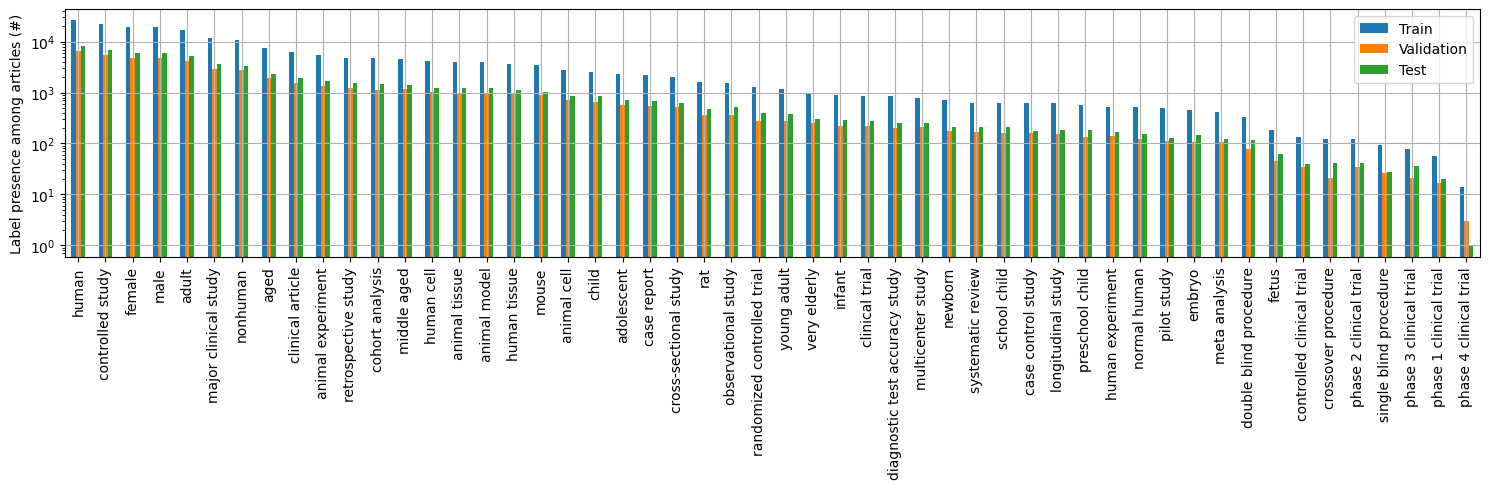

In [5]:
"""Plot the count of labels in the different datasets."""
label_occurrences_train = label_columns.loc[
    label_columns.pui.isin(train_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(
    ascending=False)
label_occurrences_val = label_columns.loc[
    label_columns.pui.isin(val_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(
    ascending=False)
label_occurrences_test = label_columns.loc[
    label_columns.pui.isin(test_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(
    ascending=False)
label_occurrences = pd.concat([label_occurrences_train, label_occurrences_val, label_occurrences_test], axis=1)
label_occurrences.rename({0: 'Train', 1: 'Validation', 2: 'Test'}, inplace=True, axis=1)
label_occurrences.plot(kind='bar', figsize=(15, 5))
plt.ylabel(f'Label presence among articles (#)')
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig('test.png', dpi=300)

In [6]:
embedding_df = data_loader.load_scibert_embeddings_csv()
mean_df = embedding_df[embedding_df.columns.difference(['pui'])].mean()
std_df = embedding_df[embedding_df.columns.difference(['pui'])].std()
embedding_df[embedding_df.columns.difference(['pui'])] = \
    (embedding_df[embedding_df.columns.difference(['pui'])] - mean_df) / std_df

X_train = embedding_df.loc[embedding_df.pui.isin(train_puis), :]
X_val = embedding_df.loc[embedding_df.pui.isin(val_puis), :]
X_test = embedding_df.loc[embedding_df.pui.isin(test_puis), :]
y_train = label_columns.loc[label_columns.pui.isin(train_puis), :]
y_val = label_columns.loc[label_columns.pui.isin(val_puis), :]
y_test = label_columns.loc[label_columns.pui.isin(test_puis), :]
        

In [7]:
np_y_test = y_test[labels].to_numpy()

In [8]:
sum(np_y_test), sum(y_test_graph_embeddings)

(array([ 712, 5144, 2342,  874, 1652, 1211, 1220,  178,  685,  846, 1947,
         279, 1449,   39, 6719,  618,   42,  248,  119,  150, 6045,   63,
        8250, 1251,  170, 1106,  283,  185, 3573, 5973,  125, 1431, 1025,
         250,  208, 3391,  155,  510,   20,   41,   36,    1,  131,  188,
         397,  470, 1551,  208,   28,  209,  308,  371]),
 array([ 698, 5267, 2349,  940, 1757, 1270, 1315,  203,  696,  782, 1948,
         280, 1498,   37, 6856,  618,   37,  252,  100,  135, 6119,   61,
        8209, 1283,  163, 1156,  268,  188, 3598, 6074,  146, 1468, 1102,
         255,  222, 3425,  163,  508,   23,   43,   29,    2,  153,  168,
         391,  494, 1529,  221,   22,  207,  327,  367]))

In [8]:
def umap_vis(embedding, target, label_names=labels, embedding_type='SciBERT'):
    n_neighbours = 10
    mapper = umap.UMAP().fit(embedding)
    
    for idx, label in enumerate(labels):
        umap.plot.points(mapper, labels=target[:, idx], color_key_cmap='Paired')
        plt.title(f'Embedding visualisation of {label} by {embedding_type}')
        plt.savefig(cc_path(f'reports/figures/embedding_visualisations/embedding_viz_{label}_{embedding_type}_{load_trained_model}_{n_neighbours}.png'), dpi=300)
        break

/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


NameError: name 'load_trained_model' is not defined

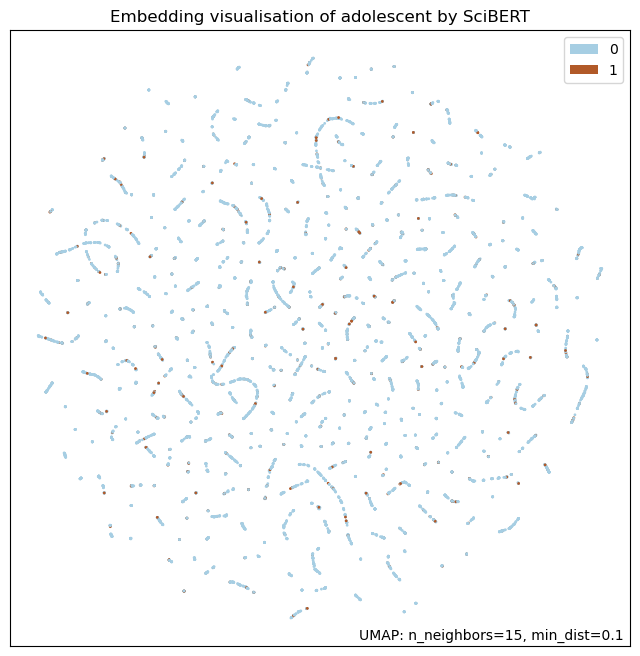

In [9]:
# visualise separative power of text embeddings
umap_vis(X_test, np_y_test, label_names=labels, embedding_type='SciBERT')
# umap_vis(X_test_graph_embeddings, y_test_graph_embeddings, label_names=labels, embedding_type='GNN')

    

NameError: name 'labels' is not defined

# visualise score vs label occurrence

In [9]:
from src.models.evaluation import Metrics


In [10]:
label_occ = label_columns[label_columns.columns.difference(['pui'])].sum(axis=0)
# label_occ = label_columns[label_columns.columns.difference(['pui'])].sum(axis=0)/ len(label_columns[label_columns.columns.difference(['pui'])])

In [11]:
predicted_labels = best_model.forward(*data_inputs, return_embeddings=False)
predicted_scibert_labels = best_scibert_model.forward(*scibert_data_inputs, return_embeddings=False)



In [12]:
metric_calculator = Metrics(predicted_labels[all_torch_data['keyword'].test_mask].detach().cpu().numpy(), all_torch_data['keyword'].y[all_torch_data['keyword'].test_mask].detach().cpu().numpy(),
                            threshold=0.5)
metrics = metric_calculator.retrieve_all_metrics()

In [13]:
metric_calculator = Metrics(predicted_scibert_labels[all_scibert_torch_data['keyword'].test_mask].detach().cpu().numpy(), all_scibert_torch_data['keyword'].y[all_scibert_torch_data['keyword'].test_mask].detach().cpu().numpy(),
                            threshold=0.5)
scibert_metrics = metric_calculator.retrieve_all_metrics()

In [14]:
metrics['F1 score']

[0.659322033898305,
 0.8772697024431979,
 0.7395856538204498,
 0.6864648772130211,
 0.9094499294781382,
 0.8642358417377813,
 0.8151658767772512,
 0.7368421052631579,
 0.9391304347826087,
 0.8400537634408602,
 0.8816368816368816,
 0.5396145610278373,
 0.7610619469026549,
 0.05128205128205129,
 0.829357027915763,
 0.8360797918473546,
 0.8059701492537312,
 0.5903890160183066,
 0.8172043010752689,
 0.5737704918032787,
 0.9203656427571439,
 0.6326530612244898,
 0.9732594262045441,
 0.7964672822159775,
 0.5342960288808664,
 0.6821480406386067,
 0.6311300639658849,
 0.6606060606060606,
 0.9043188446049161,
 0.9243229976274236,
 0.8531468531468531,
 0.4465753424657534,
 0.9197615772581385,
 0.5763546798029557,
 0.5588235294117647,
 0.919103458512691,
 0.6644518272425248,
 0.6844014510278114,
 0.46511627906976744,
 0.4864864864864865,
 0.4888888888888889,
 0.0,
 0.7472527472527473,
 0.416988416988417,
 0.8450331125827816,
 0.9213483146067417,
 0.8452463566967384,
 0.44372990353697744,
 0.29629

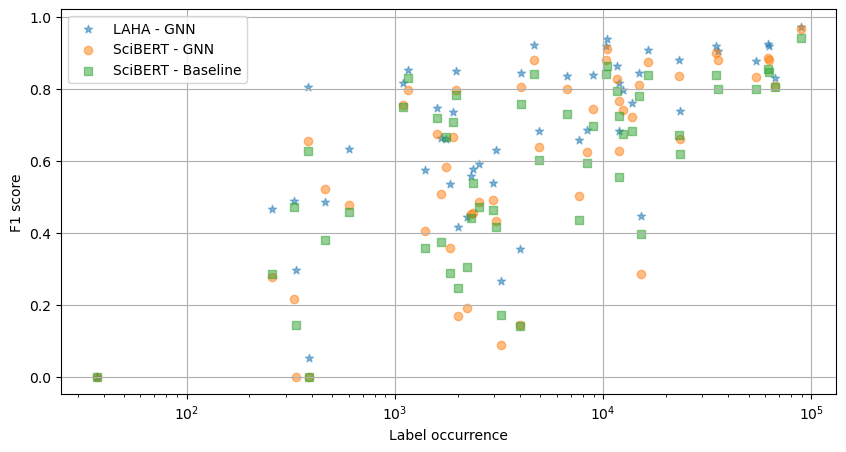

In [42]:
fig, ax = plt.subplots(figsize=(10,5))

phi = np.linspace(0, 2*np.pi, 52)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = (np.stack((np.cos(phi          ), # Three sinusoids,
                       np.cos(phi+2*np.pi/3), # 120° phase shifted,
                       np.cos(phi-2*np.pi/3)
                      )).T # Shape = (60,3)
             + 1)*0.5 

plt.ylabel('F1 score')
plt.xlabel('Label occurrence')
plt.grid()
plt.xscale('log')

# percentages
# plt.scatter(label_occ*100, metrics['F1 score'], marker='o', label='GNN', alpha=0.5)
# plt.scatter(label_occ*100, scibert_f1, marker='s', label='SciBERT - Baseline', alpha=0.5)

# raw count
plt.scatter(label_occ, metrics['F1 score'], marker='*', label='LAHA - GNN', alpha=0.5)
plt.scatter(label_occ, scibert_metrics['F1 score'], marker='o', label='SciBERT - GNN', alpha=0.5)
plt.scatter(label_occ, scibert_f1, marker='s', label='SciBERT - Baseline', alpha=0.5)

# plt.scatter(metrics['F1 score'], label_occ, marker='*', label='LAHA - GNN', alpha=0.5)
# plt.scatter(scibert_metrics['F1 score'], label_occ, marker='s', label='SciBERT - GNN', alpha=0.5)
# plt.scatter(scibert_f1, label_occ,  marker='s', label='SciBERT - Baseline', alpha=0.5)

# diffs
# plt.scatter(label_occ, np.array(metrics['F1 score']) - np.array(scibert_f1)), marker='o', label='GNN', alpha=0.5)

plt.legend()
# plt.legend([f'{i}: {label}' for i, label in enumerate(label_columns[label_columns.columns.difference(['pui'])].columns)])
# for i, txt in enumerate(label_columns[label_columns.columns.difference(['pui'])].columns):
#     ax.annotate(str(i), (label_occ[i]*100, metrics['F1 score'][i]))
plt.savefig(cc_path(f'reports/figures/label_occ_f1_laha.png'), dpi=300)

In [33]:
sorted_scibert_f1_scores = dict(sorted(scibert_f1_scores.items()))
scibert_f1 = list(sorted_scibert_f1_scores.values())

In [15]:
scibert_f1_scores  = {'human': 0.9429447394002842,
 'mouse': 0.8418732782369146,
 'rat': 0.8416547788873039,
 'nonhuman': 0.8381358946993952,
 'controlled study': 0.8063599354789154,
 'animal experiment': 0.8392921632358251,
 'animal tissue': 0.7259849490925189,
 'animal model': 0.7934678194044187,
 'animal cell': 0.5928074245939676,
 'major clinical study': 0.7995053331272223,
 'clinical article': 0.6718750000000001,
 'case report': 0.862488306828812,
 'multicenter study': 0.5373134328358209,
 'systematic review': 0.783132530120482,
 'meta analysis': 0.8311688311688312,
 'observational study': 0.6019108280254778,
 'pilot study': 0.7196261682242991,
 'longitudinal study': 0.6666666666666666,
 'retrospective study': 0.7802371541501976,
 'case control study': 0.7079037800687284,
 'cohort analysis': 0.6829488919041158,
 'cross-sectional study': 0.7299006323396569,
 'diagnostic test accuracy study': 0.47058823529411764,
 'double blind procedure': 0.75,
 'crossover procedure': 0.6285714285714286,
 'single blind procedure': 0.14285714285714288,
 'adult': 0.8002574554816563,
 'aged': 0.6198727791182276,
 'middle aged': 0.39798039798039797,
 'child': 0.6973788721207307,
 'adolescent': 0.43541102077687444,
 'young adult': 0.13965087281795513,
 'very elderly': 0.17008797653958943,
 'infant': 0.41666666666666663,
 'school child': 0.3058103975535168,
 'newborn': 0.4401294498381877,
 'preschool child': 0.24719101123595505,
 'embryo': 0.3575418994413408,
 'fetus': 0.45652173913043476,
 'male': 0.8546144121365359,
 'female': 0.8480892924706773,
 'human cell': 0.67591763652641,
 'human tissue': 0.554661618551822,
 'normal human': 0.375,
 'human experiment': 0.28806584362139914,
 'phase 2 clinical trial': 0.38095238095238093,
 'randomized controlled trial': 0.7577854671280276,
 'clinical trial': 0.46228710462287104,
 'controlled clinical trial': 0.0,
 'phase 3 clinical trial': 0.47058823529411764,
 'phase 1 clinical trial': 0.2857142857142857,
 'phase 4 clinical trial': 0.0}

scibert_precision = {'human': 0.9262523872484207,
 'mouse': 0.8358862144420132,
 'rat': 0.8753709198813057,
 'nonhuman': 0.8124137931034483,
 'controlled study': 0.6939450026441036,
 'animal experiment': 0.8120195667365478,
 'animal tissue': 0.6431372549019608,
 'animal model': 0.738819320214669,
 'animal cell': 0.5024582104228122,
 'major clinical study': 0.7227501397428732,
 'clinical article': 0.6238839285714286,
 'case report': 0.8681732580037664,
 'multicenter study': 0.5595854922279793,
 'systematic review': 0.7831325301204819,
 'meta analysis': 0.768,
 'observational study': 0.7325581395348837,
 'pilot study': 0.7549019607843137,
 'longitudinal study': 0.7322834645669292,
 'retrospective study': 0.7540106951871658,
 'case control study': 0.7923076923076923,
 'cohort analysis': 0.7082551594746717,
 'cross-sectional study': 0.7026086956521739,
 'diagnostic test accuracy study': 0.4549763033175355,
 'double blind procedure': 0.76,
 'crossover procedure': 0.7857142857142857,
 'single blind procedure': 1.0,
 'adult': 0.7191054559475613,
 'aged': 0.5356330553449583,
 'middle aged': 0.3022101939557961,
 'child': 0.7126623376623377,
 'adolescent': 0.4496268656716418,
 'young adult': 0.224,
 'very elderly': 0.3333333333333333,
 'infant': 0.49382716049382713,
 'school child': 0.3067484662576687,
 'newborn': 0.5074626865671642,
 'preschool child': 0.25,
 'embryo': 0.45714285714285713,
 'fetus': 0.44680851063829785,
 'male': 0.7997815799053513,
 'female': 0.7837412587412588,
 'human cell': 0.634453781512605,
 'human tissue': 0.4966101694915254,
 'normal human': 0.4431818181818182,
 'human experiment': 0.35,
 'phase 2 clinical trial': 0.41379310344827586,
 'randomized controlled trial': 0.7398648648648649,
 'clinical trial': 0.4947916666666667,
 'controlled clinical trial': 0.0,
 'phase 3 clinical trial': 0.6153846153846154,
 'phase 1 clinical trial': 0.36363636363636365,
 'phase 4 clinical trial': 0.0}

scibert_recall = {'human': 0.9602497715504112,
 'mouse': 0.8479467258601554,
 'rat': 0.8104395604395604,
 'nonhuman': 0.8655400440852314,
 'controlled study': 0.9622364802933089,
 'animal experiment': 0.8684603886397608,
 'animal tissue': 0.8333333333333334,
 'animal model': 0.8568464730290456,
 'animal cell': 0.7227722772277227,
 'major clinical study': 0.8945001729505362,
 'clinical article': 0.7278645833333334,
 'case report': 0.8568773234200744,
 'multicenter study': 0.5167464114832536,
 'systematic review': 0.7831325301204819,
 'meta analysis': 0.9056603773584906,
 'observational study': 0.5108108108108108,
 'pilot study': 0.6875,
 'longitudinal study': 0.6118421052631579,
 'retrospective study': 0.8083538083538083,
 'case control study': 0.639751552795031,
 'cohort analysis': 0.6593886462882096,
 'cross-sectional study': 0.7593984962406015,
 'diagnostic test accuracy study': 0.4873096446700508,
 'double blind procedure': 0.7402597402597403,
 'crossover procedure': 0.5238095238095238,
 'single blind procedure': 0.07692307692307693,
 'adult': 0.9020556227327691,
 'aged': 0.7355543987506507,
 'middle aged': 0.5826086956521739,
 'child': 0.6827371695178849,
 'adolescent': 0.4220665499124343,
 'young adult': 0.10144927536231885,
 'very elderly': 0.1141732283464567,
 'infant': 0.36036036036036034,
 'school child': 0.3048780487804878,
 'newborn': 0.38857142857142857,
 'preschool child': 0.24444444444444444,
 'embryo': 0.29357798165137616,
 'fetus': 0.4666666666666667,
 'male': 0.9175193150970975,
 'female': 0.9239488870568837,
 'human cell': 0.7231800766283525,
 'human tissue': 0.6280814576634512,
 'normal human': 0.325,
 'human experiment': 0.24475524475524477,
 'phase 2 clinical trial': 0.35294117647058826,
 'randomized controlled trial': 0.776595744680851,
 'clinical trial': 0.4337899543378995,
 'controlled clinical trial': 0.0,
 'phase 3 clinical trial': 0.38095238095238093,
 'phase 1 clinical trial': 0.23529411764705882,
 'phase 4 clinical trial': 0.0}

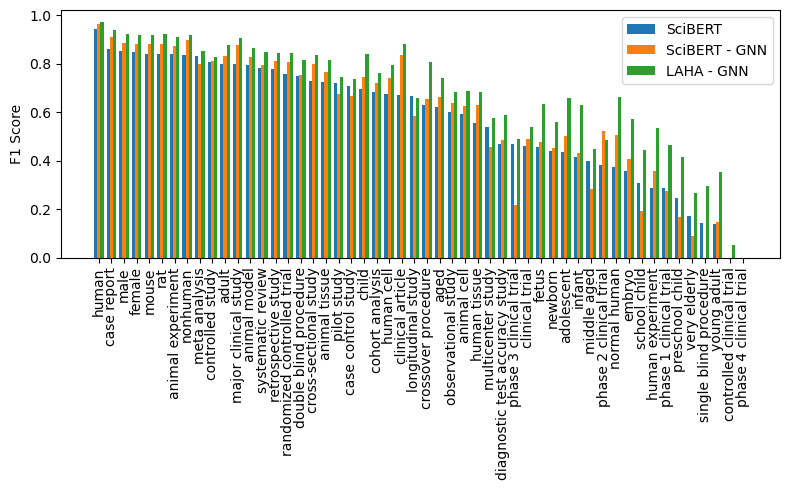

In [29]:
labels = dict(sorted(scibert_f1_scores.items())).keys()
x = np.array(range(len(labels)))
width = 0.25

scores_lists = list(zip(labels, scibert_f1, scibert_metrics['F1 score'],  metrics['F1 score']))
scores_lists.sort(key = lambda i:i[1], reverse = True)


fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x, list(zip(*scores_lists))[1], width, label='SciBERT')
rects2 = ax.bar(x + width, list(zip(*scores_lists))[2], width, label='SciBERT - GNN')
rects2 = ax.bar(x + 2*width, list(zip(*scores_lists))[3], width, label='LAHA - GNN')

plt.ylabel('F1 Score')
ax.set_xticks(x+width)
ax.set_xticklabels(list(zip(*scores_lists))[0], rotation = 90)
ax.legend()
plt.tight_layout()
plt.savefig(cc_path(f'reports/figures/scibert_gnn_f1_per_label.png'), dpi=300)